In [3]:
import h5py

def explore_h5(file_path):
    """
    Mở file .h5 và in ra cấu trúc:
      - Các group và dataset
      - Hình dạng (shape) và kiểu dữ liệu (dtype) của mỗi dataset
    """
    with h5py.File(file_path, 'r') as f:
        print(f"Root groups/datasets in '{file_path}':")
        for key in f.keys():
            print(f"  - {key}: {type(f[key]).__name__}")
        
        def print_item(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  shape: {obj.shape}")
                print(f"  dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"Group:   {name}")
        
        print("\nDetailed structure:")
        f.visititems(print_item)

if __name__ == "__main__":
    # Thay 'your_file.h5' bằng đường dẫn tới file của bạn
    explore_h5('datasets/ACDC/ACDC_training_volumes/patient001_frame01.h5')


Root groups/datasets in 'datasets/ACDC/ACDC_training_volumes/patient001_frame01.h5':
  - image: Dataset
  - label: Dataset
  - scribble: Dataset

Detailed structure:
Dataset: image
  shape: (10, 256, 216)
  dtype: float32
Dataset: label
  shape: (10, 256, 216)
  dtype: uint8
Dataset: scribble
  shape: (10, 256, 216)
  dtype: uint16


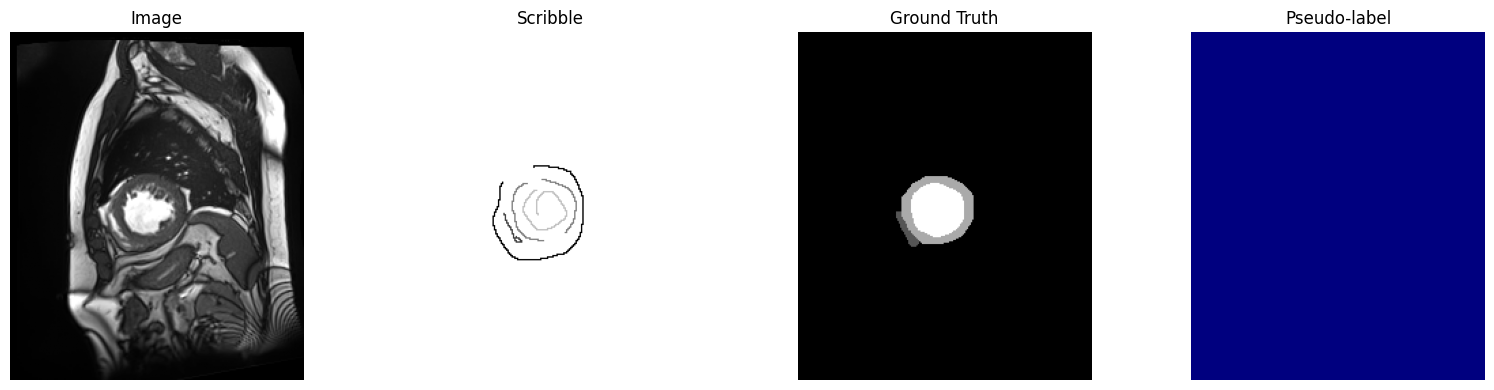

In [7]:
import h5py
import matplotlib.pyplot as plt

def show_h5_pseudolabel(path_to_file):
    """
    Đọc file .h5 và hiển thị:
      1. Ảnh gốc
      2. Scribble
      3. Ground-truth
      4. Pseudo-label (SAM_PL)
    """
    with h5py.File(path_to_file, 'r') as f:
        img       = f['image'][:]       # HxW
        scribble  = f['scribble'][:]    # HxW
        label_gt  = f['label'][:]       # HxW
        pseudo    = f['SAM_PL'][:]      # HxW

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(img,      cmap='gray'); axes[0].set_title('Image')
    axes[1].imshow(scribble, cmap='gray'); axes[1].set_title('Scribble')
    axes[2].imshow(label_gt, cmap='gray'); axes[2].set_title('Ground Truth')
    axes[3].imshow(pseudo,   cmap='jet');  axes[3].set_title('Pseudo-label')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Ví dụ sử dụng:
show_h5_pseudolabel('datasets/ACDC/ACDC_training_SAM_PL_iteration1/patient001_frame12_slice_6.h5')


--- Showing patient072_frame01_slice_7.h5 ---


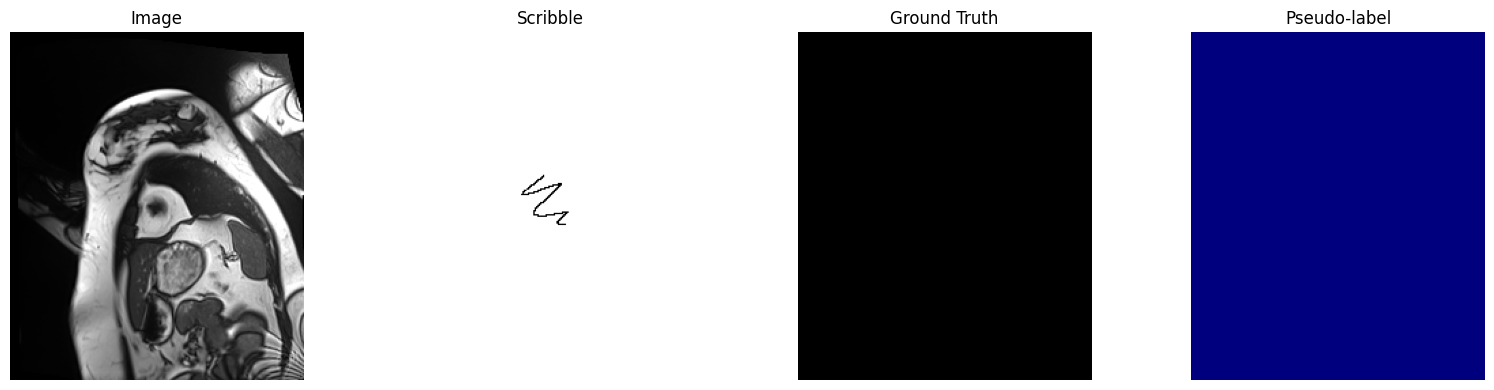

--- Showing patient012_frame01_slice_8.h5 ---


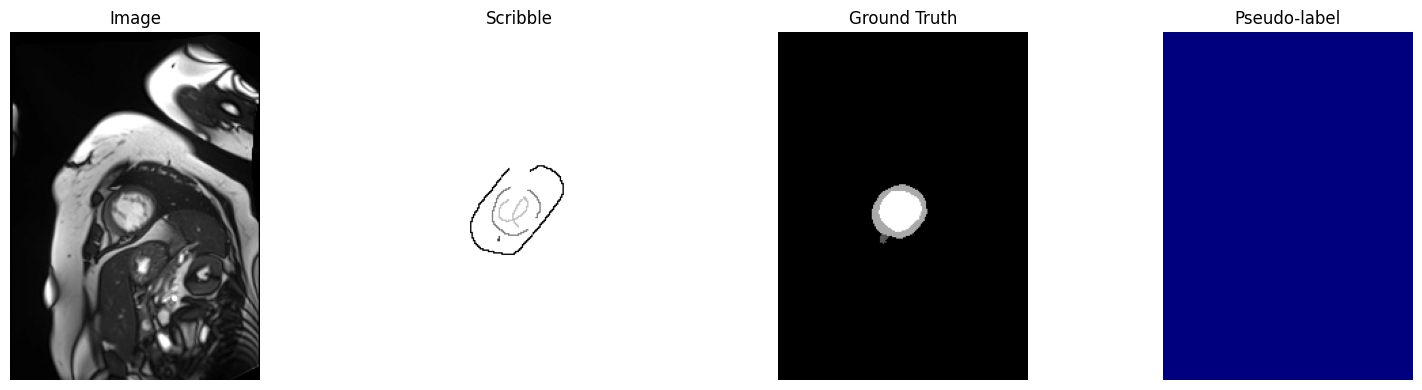

--- Showing patient003_frame15_slice_1.h5 ---


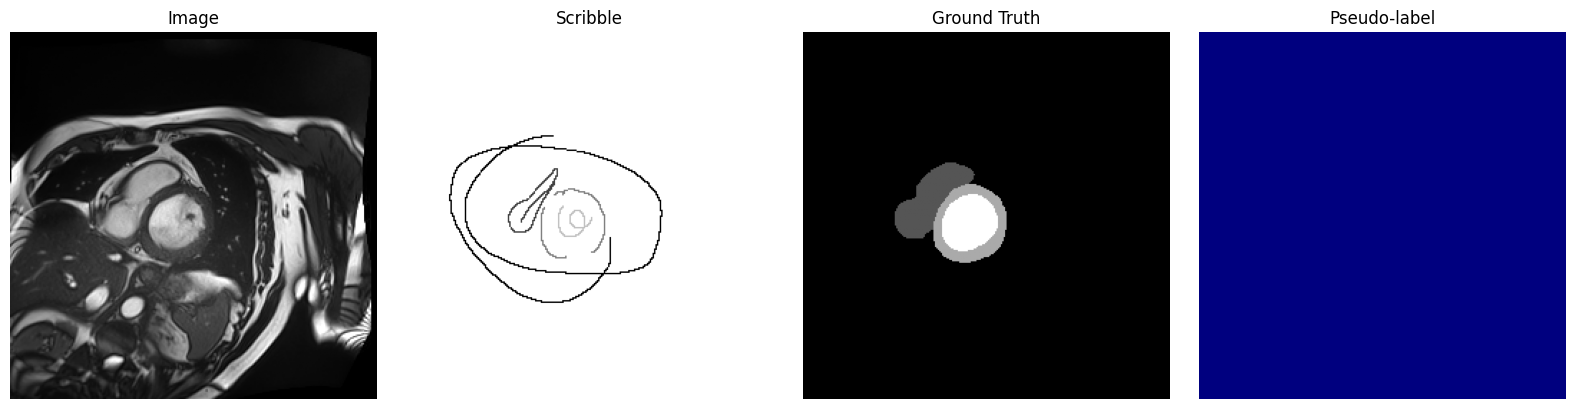

--- Showing patient082_frame07_slice_8.h5 ---


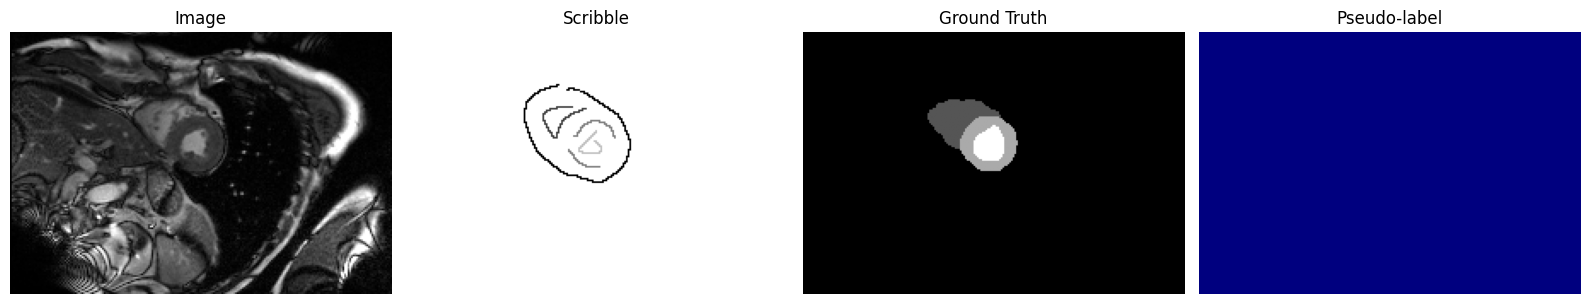

--- Showing patient030_frame01_slice_5.h5 ---


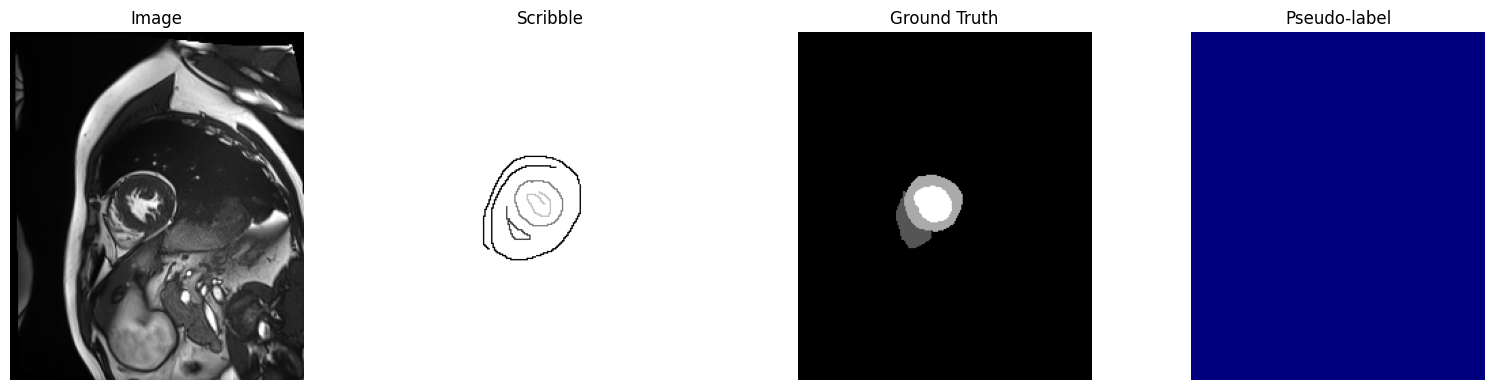

--- Showing patient027_frame01_slice_5.h5 ---


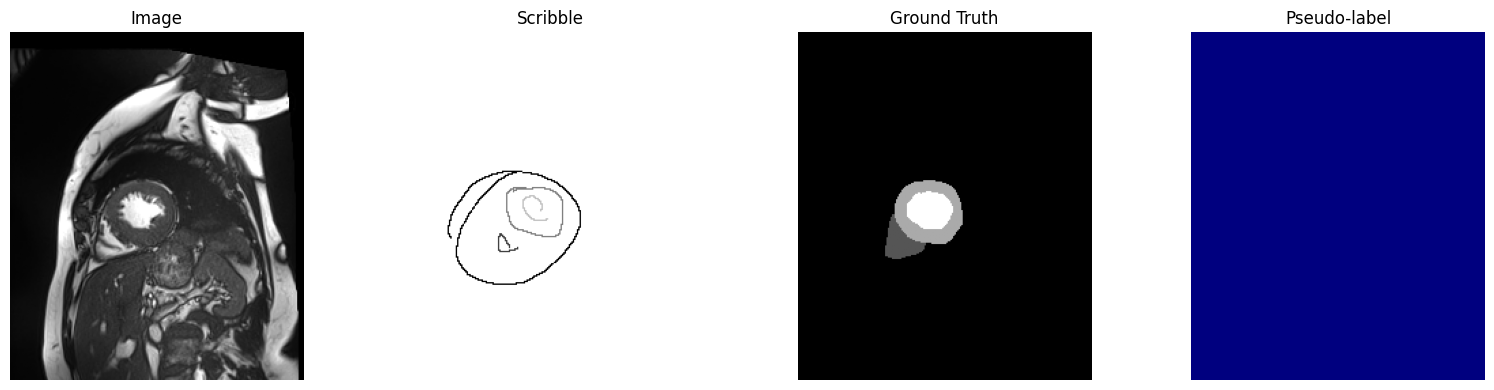

--- Showing patient024_frame09_slice_7.h5 ---


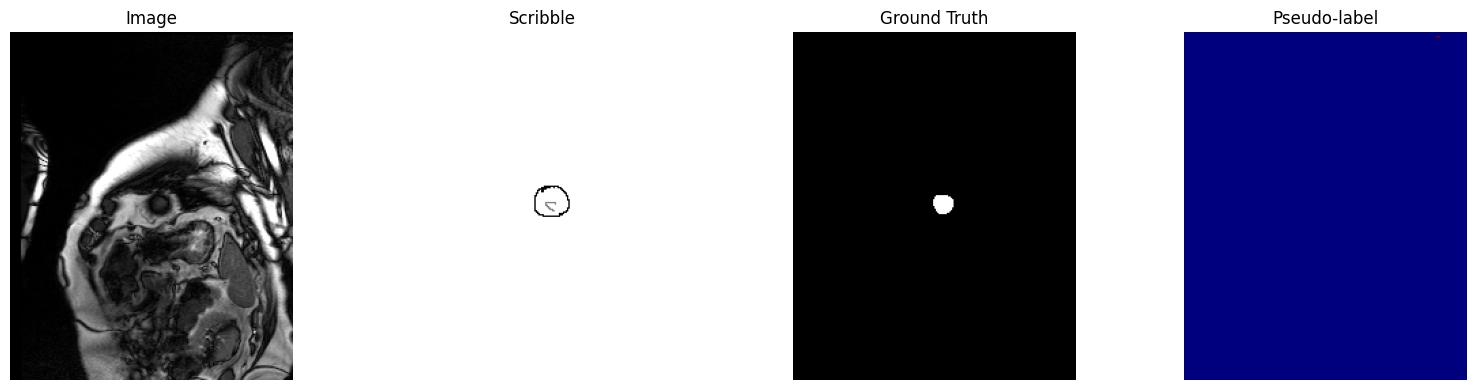

--- Showing patient015_frame01_slice_5.h5 ---


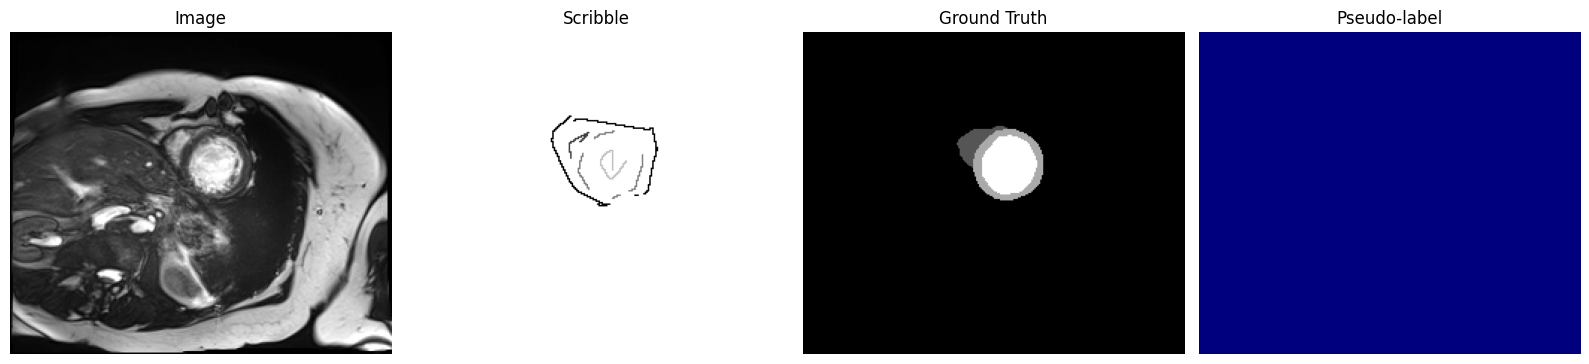

--- Showing patient082_frame07_slice_12.h5 ---


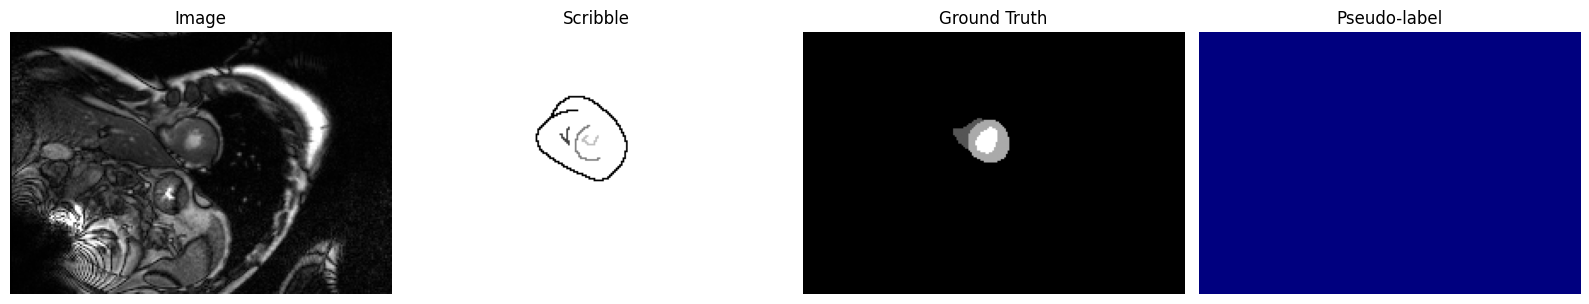

--- Showing patient011_frame01_slice_7.h5 ---


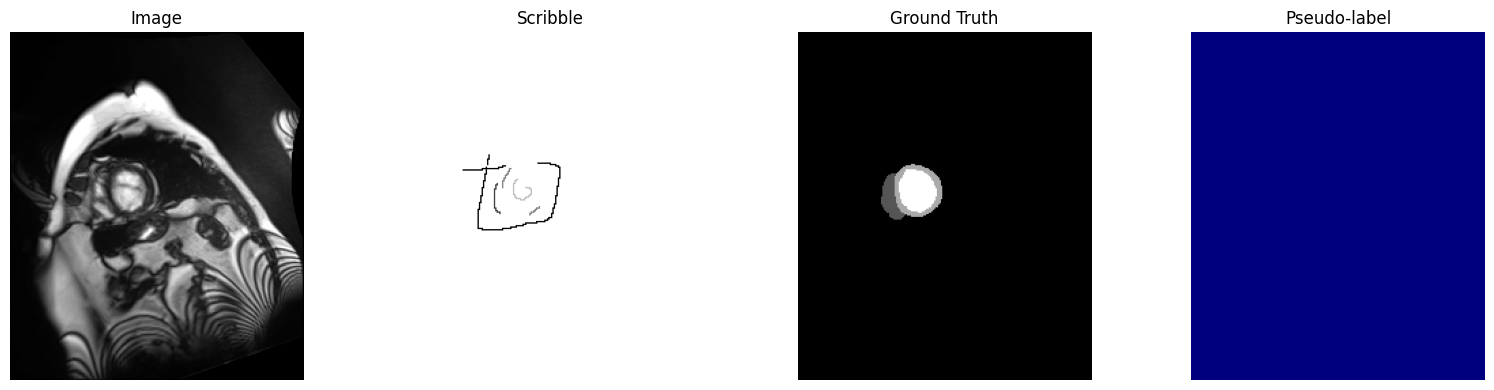

In [8]:
import os
import random
import h5py
import matplotlib.pyplot as plt

def show_h5_pseudolabel(path_to_file):
    """
    Đọc file .h5 và hiển thị:
      1. Ảnh gốc
      2. Scribble
      3. Ground-truth
      4. Pseudo-label (SAM_PL)
    """
    with h5py.File(path_to_file, 'r') as f:
        img       = f['image'][:]       # HxW
        scribble  = f['scribble'][:]    # HxW
        label_gt  = f['label'][:]       # HxW
        pseudo    = f['SAM_PL'][:]      # HxW

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(img,      cmap='gray'); axes[0].set_title('Image')
    axes[1].imshow(scribble, cmap='gray'); axes[1].set_title('Scribble')
    axes[2].imshow(label_gt, cmap='gray'); axes[2].set_title('Ground Truth')
    axes[3].imshow(pseudo,   cmap='jet');  axes[3].set_title('Pseudo-label')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_random_pseudolabels(folder, n=10, seed=42):
    """
    Lặp qua thư mục `folder`, chọn ngẫu nhiên `n` file .h5,
    và hiển thị nội dung mỗi file bằng hàm show_h5_pseudolabel.
    """
    # Lấy danh sách tất cả file .h5 trong folder
    all_files = [os.path.join(folder, fn)
                 for fn in os.listdir(folder)
                 if fn.lower().endswith('.h5')]
    if not all_files:
        raise RuntimeError(f"No .h5 files found in {folder}")

    # Thiết lập seed để reproducible
    random.seed(seed)
    # Chọn ngẫu nhiên n file (hoặc tất cả nếu < n)
    selected = random.sample(all_files, k=min(n, len(all_files)))

    # Hiển thị từng file
    for path in selected:
        print(f"--- Showing {os.path.basename(path)} ---")
        show_h5_pseudolabel(path)

if __name__ == "__main__":
    # Thay đổi đường dẫn tới folder chứa pseudo-label .h5
    folder_path = "datasets/ACDC/ACDC_training_SAM_PL_iteration1"
    show_random_pseudolabels(folder_path, n=10)


In [9]:
import torch
from torch.utils.data import DataLoader
from dataset.dataset_ACDC import BaseDataSets_SAM_pred, RandomGenerator_SAM_pred
from torchvision.transforms import transforms

def debug_batch_shapes():
    # Cấu hình giống Stage1
    base_dir = "datasets/ACDC"
    dataset = BaseDataSets_SAM_pred(
        base_dir=base_dir,
        split="train",
        fold='fold1',
        sup_type='scribble',
        pseudo_label='SAM_PL',
        transform=transforms.Compose([RandomGenerator_SAM_pred([256,256])])
    )
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    batch = next(iter(loader))
    image_t   = batch['image']      # Expect [1, 3, H, W]
    scribble_t= batch['scribble']   # Expect [1, H, W]
    label_t   = batch['label']      # Expect [1, H, W]

    print("image_t.shape   =", image_t.shape)
    print("scribble_t.shape=", scribble_t.shape)
    print("label_t.shape   =", label_t.shape)

    # Lấy channel đầu tiên của ảnh xám
    orig_gray = image_t[0,0].cpu().numpy()
    print("orig_gray.shape =", orig_gray.shape)

    # So sánh với scribble và label
    assert orig_gray.shape == scribble_t[0].shape == label_t[0].shape, \
        "Kích thước không khớp giữa image, scribble và label!"

    print("✅ All shapes match. image_t[0,0] đúng là ảnh xám H×W.")

if __name__ == "__main__":
    debug_batch_shapes()


total 1902 samples
image_t.shape   = torch.Size([1, 3, 256, 216])
scribble_t.shape= torch.Size([1, 256, 216])
label_t.shape   = torch.Size([1, 256, 216])
orig_gray.shape = (256, 216)
✅ All shapes match. image_t[0,0] đúng là ảnh xám H×W.


In [ ]:
import os, h5py, numpy as np, matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from my_utils.Sampling_Combine import contour_sample, combine

base_dir   = "/path/to/ACDC"
checkpoint = "SAM_Finetune/sam_vit_h_4b8939.pth"
device     = "cuda" if torch.cuda.is_available() else "cpu"
sam        = sam_model_registry['vit_h'](checkpoint).to(device)
pred       = SamPredictor(sam)

# Danh sách file muốn test:
files_to_test = [
    "pdatasets/ACDC/ACDC_training_slices/patient001_frame01_slice_3.h5",
    "datasets/ACDC/ACDC_training_slices/patient001_frame12_slice_8.h5",
    "datasets/ACDC/ACDC_training_slices/patient003_frame15_slice_4.h5",
    "datasets/ACDC/ACDC_training_slices/patient005_frame13_slice_0.h5",
    "datasets/ACDC/ACDC_training_slices/patient010_frame01_slice_4.h5"
    # ...
]

for fn in files_to_test:
    path = os.path.join(base_dir, "ACDC_training_slices", fn)
    with h5py.File(path,'r') as f:
        img       = f['image'][:]       # HxW
        scribble  = f['scribble'][:]    # HxW
        label_gt  = f['label'][:]       # HxW

    # build image_np
    img_np = (img*255).astype(np.uint8)
    img_np = np.stack([img_np]*3, axis=2)

    # chuyển scribble sang tensor để contour_sample
    scrib_t = torch.from_numpy(scribble).unsqueeze(0).to(device)  # [1,H,W]
    pts_lv = contour_sample(scrib_t, 1, 10)
    print(fn, "-> pts_lv:", pts_lv)

    # predict nếu có pts
    if pts_lv:
        pred.set_image(img_np)
        masks, _, _ = pred.predict(point_coords=np.array(pts_lv),
                                   point_labels=np.ones(len(pts_lv)),
                                   multimask_output=False)
        plt.figure(figsize=(6,6))
        plt.imshow(img, cmap='gray')
        plt.imshow(masks[0], alpha=0.5)
        plt.title(fn)
        plt.axis('off')
        plt.show()
    else:
        print("  Không có prompt cho LV -> auto bỏ qua")
